In [1]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage import io, transform
import os
from PIL import Image

from torchvision import models
from torch.nn import Sequential, Linear

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df=pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [5]:
print(df["classname"].value_counts())

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


In [6]:
def balance_df(df, cls):
    max_size = df[cls].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby(cls):
        lst.append(group.sample(max_size-len(group), replace=True))
    frame_new = pd.concat(lst)
    df2=frame_new
    df3=df2.sample(frac=1) # randomise
    return(df3)

df = balance_df(df, 'classname')

In [7]:
df["classname"].value_counts()

c6    2489
c2    2489
c0    2489
c7    2489
c8    2489
c5    2489
c1    2489
c3    2489
c4    2489
c9    2489
Name: classname, dtype: int64

In [8]:
df.to_csv('balanced.csv')

In [9]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))
    

In [10]:
# custom class

class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx): 
        smol_img_path = str(self.d.iloc[idx][3])
        class_name = str(self.d.iloc[idx][2])[-1] #only the number
        full_img_path = self.root_dir + '/' + 'c'+ class_name + '/' + smol_img_path #oof part
        img_arr = image_to_nparray(full_img_path)
        
#         if self.transform is not None:
#             img_arr = self.transform(img_arr)

        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return torch.tensor(int(class_name)), img_arr    
        
        

    def __len__(self):
        return (len(self.d))



In [11]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [12]:
data = C_Dataset('balanced.csv', 
               '../input/state-farm-distracted-driver-detection/imgs/train',
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((150,150), interpolation=2),
                                                transforms.RandomRotation(10),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.05)
                                                ])
                )

print(len(data))

24890


In [13]:
train_set, val_set = torch.utils.data.random_split(data, [len(data)-4000, 4000])

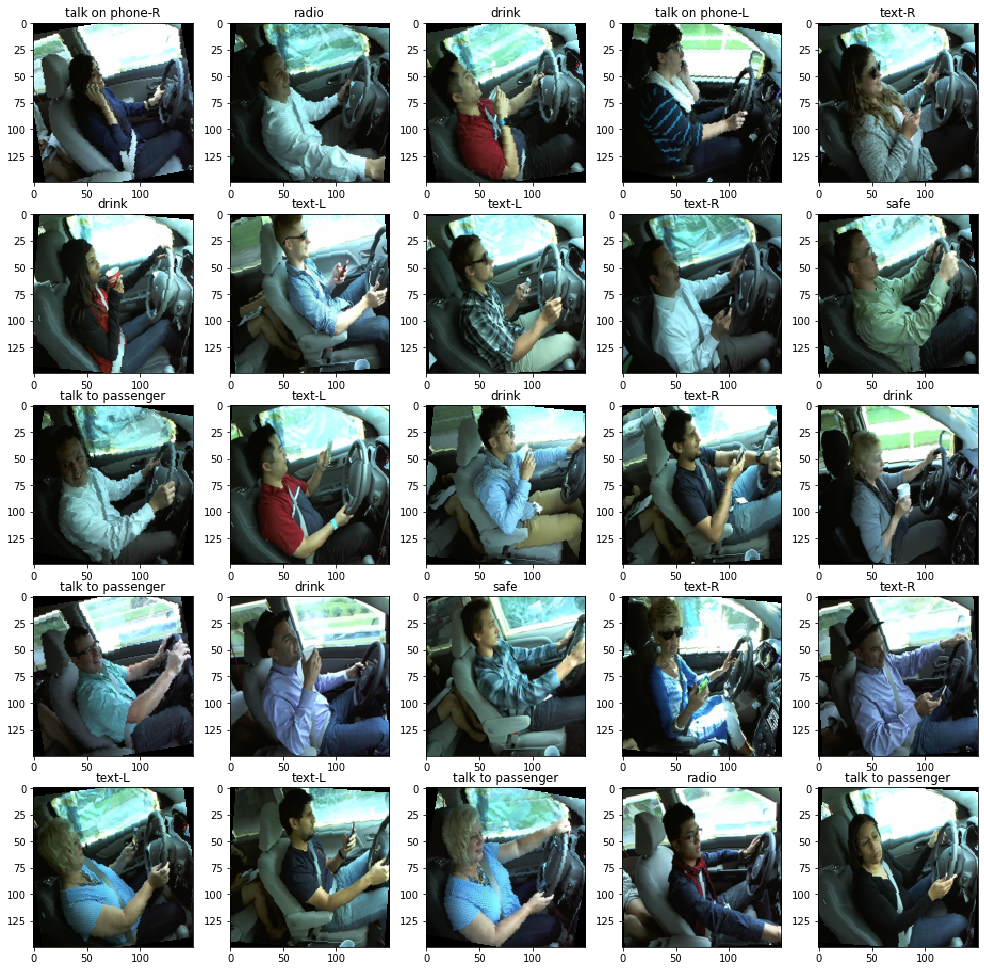

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [14]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=10
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(5, 5, figsize=(17,17))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for labels,images in (train_loader_1):
            
            x=np.transpose(images[0], (1, 2, 0))  
            class_number = labels[0].item()
            im_label=class_list[class_number]
            axs[j,i].imshow(x, interpolation='none')
            axs[j,i].title.set_text(im_label)
            break
plt.show()
            
# c0: safe driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger

In [15]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.conv5 = nn.Conv2d(16, 16, 3)
        
        self.fc1 = nn.Linear(16*2*2, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        #print(x.shape)
        x = x.view(-1, 16*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        

network=Net()
network = network.to(device)

In [16]:
print(network)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
